In [156]:
import numpy as np
import cvxopt
import struct
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import matplotlib.cm as cmx
import matplotlib.colors as colors

### Control_horizon=1, planning_horizon=1

In [397]:
del_t = 0.1
v_init = 10
w_init = 0.1
a_max = 10
alpha_min = -0.5
alpha_max = 0.5

class agent:
    def __init__(self,rad,start,goal,theta,vmax,wmax):
        self.rad = rad
        self.xpath = []
        self.ypath = []
        self.vplot = []
        self.wplot = []
        self.time = 0
        self.goal = goal
        self.theta = theta
        self.v = v_init
        self.w = w_init
        self.pos = start
        self.vmax = vmax
        self.wmax = wmax
        
    def __str__(self):
        return (str(self.time)+" "+str(self.theta)+" "+str(self.v)+" "+str(self.w)+" "+str(self.pos))    
            

    def opt_traj(self):
        self.visualize_traj()
        print ("start v: ",self.v,"start w: ",self.w)
        while (np.linalg.norm(self.pos-self.goal)>0.5):
            x_new = self.pos[0] + self.v*del_t*np.cos(self.theta+self.w*del_t)
            y_new = self.pos[1] + self.v*del_t*np.sin(self.theta+self.w*del_t)
            self.theta += self.w*del_t
            self.xpath.append(x_new)
            self.ypath.append(y_new)
            self.pos = [x_new,y_new]
            theta_new = self.theta
            v_new = self.v
            w_new = self.w
            diff_v = 999
            diff_w = 999
#             xgi = self.pos[0]
#             ygi = self.pos[1]
            tol = 1e-1
            while (np.linalg.norm(np.array([diff_w,diff_v])**2)>tol):
                # vi = self.v, wi = self.w
#                 theta_new += self.w*del_t
#                 xgi += (self.v*del_t*np.cos(theta_new) - self.goal[0])
#                 ygi += (self.v*del_t*np.sin(theta_new) - self.goal[1])
                w_guess = self.w
                v_guess = self.v
                x = del_t*np.cos(self.theta+w_guess*del_t)
                a = -v_guess*del_t**2*np.sin(self.theta+w_guess*del_t)
                y = del_t*np.sin(self.theta+w_guess*del_t)
                b = v_guess*del_t**2*np.cos(self.theta+w_guess*del_t)
                kx = self.pos[0]+v_guess*del_t**2*w_guess*np.sin(self.theta+w_guess*del_t) - self.goal[0]
                ky = self.pos[1]-v_guess*del_t**2*w_guess*np.cos(self.theta+w_guess*del_t) - self.goal[1]
                arrx = np.array([[x],[a]])
                arry = np.array([[y],[b]])
                p_mat = 2*(np.matmul(arrx,arrx.T)+np.matmul(arry,arry.T))
                P = cvxopt.matrix(p_mat,tc='d')
                q_mat = 2*(kx*arrx+ky*arry)
                Q = cvxopt.matrix(q_mat,tc='d')
                g_mat = np.array([[0,-1],[-1,0],[1,0],[0,1],[1,0],[0,1]])
                h = cvxopt.matrix(np.array([self.wmax,0,self.vmax,self.wmax,v_guess+5,w_guess+0.01]),tc='d')
#                 print (arrx,arry,kx,ky)
                g = cvxopt.matrix(g_mat,tc='d')
                sol = cvxopt.solvers.qp(P,Q,g,h,options={'show_progress': False})
                v_new = sol['x'][0] #vd
                w_new = sol['x'][1] #wd
#                 print ("Optimizer op:",v_new,w_new)
#                 print (v_new,w_new)
                diff_v = v_new - self.v
                diff_w = w_new - self.w
                print (diff_v,diff_w)
                self.v = v_new #vd+vi
                self.w = w_new #wd+wi
            print ("#####################End of Optimization######################")
#             print ("new v: ",self.v,"new w: ",self.w)
#             print ("Opti complete")
#             self.vplot.append(self.v)
#             self.wplot.append(self.w)
            print (self)
            self.time+=1
            self.visualize_traj()

             
    def visualize_traj(self):
        figure = plt.figure()
#         print (self.pos)
        print ("Theta: ",self.theta)
        ax = figure.add_subplot(1,1,1)
        robot = matplotlib.patches.Rectangle(
            (self.pos[0]-self.rad*np.sqrt(2)*np.cos(self.theta+np.pi/4),self.pos[1]-self.rad*np.sqrt(2)*np.sin(self.theta+np.pi/4)),
            height = self.rad*2,
            width = self.rad*2,
            angle = self.theta*180/np.pi,
            edgecolor='black',
            linewidth=1.0,
            animated=True,
            alpha=1,
            zorder=2)
        ax.add_patch(robot)
        name = 'data/snap%s.png'%str(self.time)
        ax.plot([self.goal[0]], [self.goal[1]], '*', color="red", markersize =15,linewidth=3.0)
        ax.plot(self.xpath,self.ypath,'b-')
        ax.set_aspect('equal')
        ax.set_xlim(-10.0, 100.0)
        ax.set_ylim(-10.0, 100.0)
        ax.set_xlabel(r'$x (m)$')
        ax.set_ylabel(r'$y (m)$')
        ax.grid(True)
        plt.savefig(name, dpi = 200)
        plt.cla()
        plt.close(figure)
        return figure
    


Theta:  1.5707963267948966
start v:  10 start w:  0.1
4.999999833519752 -0.5999999534260747
4.999998684841277 2.9545122401941626e-06
1.4064520748036102e-06 -2.8126284190022055e-06
#####################End of Optimization######################
0 1.5807963267948966 19.999999924813103 -0.4999998115422535 [-0.009999833334166612, 0.9999500004166653]
Theta:  1.5807963267948966
9.541967216364355e-09 -2.2516700171060222e-09
#####################End of Optimization######################
1 1.5307963456406712 19.99999993435507 -0.4999998137939235 [0.06997879707703442, 2.998350207733205]
Theta:  1.5307963456406712
1.023226658958265e-08 -4.097320593920983e-09
#####################End of Optimization######################
2 1.480796364261279 19.999999944587337 -0.4999998178912441 [0.24973582025355784, 4.990255673954116]
Theta:  1.480796364261279
1.0160736252373681e-08 -5.769790201171077e-09
#####################End of Optimization######################
3 1.4307963824721546 19.999999954748073 -0.4999

-12.073935665996244 0.00999998954252912
-9.59486792914421e-08 -0.1116115816753358
#####################End of Optimization######################
36 -0.11324066284981937 3.782537271093869e-08 -0.45164563463443 [48.90060926227669, 40.41844430730588]
Theta:  -0.11324066284981937
-2.7870265513323995e-08 -0.026652000674628917
#####################End of Optimization######################
37 -0.15840522631326237 9.955107197614696e-09 -0.47829763530905894 [48.90060926601187, 40.41844430670921]
Theta:  -0.15840522631326237
-2.8384241813305285e-09 -0.00775049654885851
#####################End of Optimization######################
38 -0.20623498984416827 7.116683016284167e-09 -0.48604813185791745 [48.90060926698629, 40.41844430650536]
Theta:  -0.20623498984416827
-1.4120234137428685e-09 -0.0023990367516731337
#####################End of Optimization######################
39 -0.25483980302996 5.7046596025412985e-09 -0.4884471686095906 [48.90060926767497, 40.41844430632595]
Theta:  -0.254839803029

-1.2699879762770856e-12 0.0008097737145017492
#####################End of Optimization######################
71 -1.7898728719522 1.9193837093643798e-11 -0.4706172693454334 [48.900609270820034, 40.4184443030106]
Theta:  -1.7898728719522
1.7288026721318262e-09 0.00128270511031775
#####################End of Optimization######################
72 -1.8369345988867432 1.74799650922547e-09 -0.46933456423511566 [48.90060927081953, 40.41844430300875]
Theta:  -1.8369345988867432
-2.138760196795446e-10 0.0018449522331897006
#####################End of Optimization######################
73 -1.8838680553102547 1.5341204895459254e-09 -0.46748961200192596 [48.90060927076569, 40.418444302842445]
Theta:  -1.8838680553102547
-2.5054661775615096e-10 0.0025231976141467105
#####################End of Optimization######################
74 -1.9306170165104473 1.2835738717897744e-09 -0.46496641438777925 [48.900609270711676, 40.41844430269886]
Theta:  -1.9306170165104473
-2.7185886782653916e-10 0.0033339544457

-0.006006048300576161 4.1950587448269516e-10
#####################End of Optimization######################
105 -3.4331358315547447 4.800159738480101 -0.4999999768584942 [47.23942404353959, 40.80096731965692]
Theta:  -3.4331358315547447
-0.005999064274716304 4.069932169059598e-10
#####################End of Optimization######################
106 -3.4831358292405943 4.794160674205385 -0.49999997645150096 [46.787134313619866, 40.961744604614694]
Theta:  -3.4831358292405943
-0.005991456162448117 3.9455427813805954e-10
#####################End of Optimization######################
107 -3.5331358268857445 4.7881692180429365 -0.4999999760569467 [46.34399984906323, 41.1446970903127]
Theta:  -3.5331358268857445
-0.005983968270156126 3.8246317224377435e-10
#####################End of Optimization######################
108 -3.583135824491439 4.78218524977278 -0.4999999756744835 [45.911104683488645, 41.34931238844138]
Theta:  -3.583135824491439
-0.005976489742632651 3.7059350033175065e-10
#######

-0.005749236064872321 2.470577631363824e-10
#####################End of Optimization######################
140 -5.183135731500599 4.594596374429927 -0.4999999661911492 [41.80690323280222, 54.16951353085341]
Theta:  -5.183135731500599
-0.0057420509421088894 2.3966867379598966e-10
#####################End of Optimization######################
141 -5.233135728119714 4.588854323487818 -0.49999996595148055 [42.035497286253666, 54.568070825562565]
Theta:  -5.233135728119714
-0.005734874799462553 2.32304564473651e-10
#####################End of Optimization######################
142 -5.283135724714862 4.583119448688356 -0.499999965719176 [42.28341499746398, 54.95422189508092]
Theta:  -5.283135724714862
-0.0057277076258337445 2.2496654539239103e-10
#####################End of Optimization######################
143 -5.33313572128678 4.577391741062522 -0.49999996549420944 [42.549988819642, 55.3270331558267]
Theta:  -5.33313572128678
-0.005720549409523379 2.176559488198393e-10
###################

KeyboardInterrupt: 

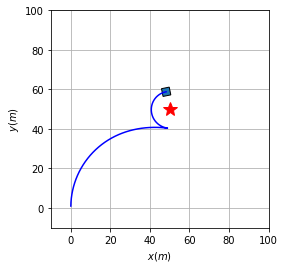

In [398]:
bot = agent(2,np.array([0,0]),np.array([50,50]),np.pi/2,20,0.5)
bot.opt_traj()

### Control_horizon = 1, planning_horizon = p

In [312]:
del_t = 0.1
planning_horizon = 10
v_guess = 10*np.ones((planning_horizon))
w_guess = 0.1*np.ones((planning_horizon))
v_init = v_guess[0]
w_init = w_guess[0]
a_max = 10
alpha_min = -0.5
alpha_max = 0.5

class mpc_agent:
    def __init__(self,rad,start,goal,theta,vmax,wmax):
        self.rad = rad
        self.xpath = []
        self.ypath = []
        self.vplot = []
        self.wplot = []
        self.time = 0
        self.goal = goal
        self.theta = theta
        self.v = v_init
        self.w = w_init
        self.v_guess = v_guess
        self.w_guess = w_guess
        self.prev_v = v_guess
        self.prev_w = w_guess
        self.pos = start
        self.vmax = vmax
        self.wmax = wmax
        
    def __str__(self):
        return (str(self.time)+" "+str(self.theta)+" "+str(self.v)+" "+str(self.w)+" "+str(self.pos))    
            
    def p_constructor(self):
#         print (self.w_guess)
        wg = np.cumsum(self.w_guess)
        p_theta = self.theta+wg*del_t
        
        xs = del_t*np.cos(p_theta)
        qx = np.sin(p_theta)
        bs = -self.v_guess*del_t**2*qx
        brev = bs[::-1]
        dterms = np.cumsum(brev)
        dterms = dterms[::-1]
        arrx = np.concatenate((xs, dterms), axis=None)
        ksx = bs*self.w_guess
        kx = np.sum(ksx) + self.pos[0] - self.goal[0]
        
        ys = del_t*np.sin(p_theta)
        qy = np.cos(p_theta)
        by = self.v_guess*del_t**2*qy
        byrev = by[::-1]
        dyterms = np.cumsum(byrev)
        dyterms = dyterms[::-1]
        arry = np.concatenate((ys, dyterms), axis=None)
        ksy = by*self.w_guess
        ky = np.sum(ksy) + self.pos[1] - self.goal[1]
        
        
        return arrx,arry,kx,ky
        
    def opt_traj(self):
        self.visualize_traj()
        print ("start v: ",self.v,"start w: ",self.w)
        
        while (np.linalg.norm(self.pos-self.goal)>0.7):
            x_new = self.pos[0] + self.v*del_t*np.cos(self.theta+self.w*del_t)
            y_new = self.pos[1] + self.v*del_t*np.sin(self.theta+self.w*del_t)
            self.theta += self.w*del_t
            self.xpath.append(x_new)
            self.ypath.append(y_new)
            self.pos = [x_new,y_new]
            theta_new = self.theta
            v_new = self.v
            w_new = self.w
            diff_v = 999
            diff_w = 999
            tol = 1e-4
            
            while (np.linalg.norm(np.array([diff_w,diff_v])**2)>tol):
                arrx,arry,kx,ky = self.p_constructor()
                arrx = arrx.reshape((-1,1))
                arry = arry.reshape((-1,1))
#                 print (arrx.shape,arry.shape,kx.shape,ky.shape)
                p_mat = 2*(np.matmul(arrx,arrx.T)+np.matmul(arry,arry.T))
                P = cvxopt.matrix(p_mat,tc='d')
                q_mat = 2*(kx*arrx+ky*arry)
                Q = cvxopt.matrix(q_mat,tc='d')
                g_mat = np.eye(2*planning_horizon)
                g_mat = np.concatenate((g_mat,-np.eye(2*planning_horizon)),axis=0)
#                 g_mat[:planning_horizon,:planning_horizon] = np.eye(planning_horizon)
#                 print (g_mat)
#                 g_mat = np.array([[0,-1],[-1,0],[1,0],[0,1]])
#                 h_mat = np.concatenate((self.wmax*np.ones(2*planning_horizon),np.zeros(2*planning_horizon),self.vmax*np.ones(2*planning_horizon),self.wmax*np.ones(2*planning_horizon)),axis=None)
#                 h = cvxopt.matrix(h_mat,tc='d')
#                 h_mat = np.array([self.wmax,0,self.vmax,self.wmax])
                h_mat = np.concatenate((self.vmax*np.ones(planning_horizon),self.wmax*np.ones(planning_horizon),np.zeros(planning_horizon),self.wmax*np.ones(planning_horizon)),axis=None)
                h = cvxopt.matrix(h_mat,tc='d')
#                 print ("h_mat:",h_mat)
#                 print ("p_mat:",p_mat)
#                 print (arrx,arry,kx,ky)
                g = cvxopt.matrix(g_mat,tc='d')
#                 print (p_mat.shape,q_mat.shape,g_mat.shape,h_mat.shape)
                sol = cvxopt.solvers.qp(P,Q,g,h,options={'show_progress': False})
                v_new = sol['x'][:planning_horizon] #vd
                w_new = sol['x'][planning_horizon:] #wd
#                 print ("Optimizer op:",v_new,w_new)
                diff_v = v_new[0] - self.v
                diff_w = w_new[0] - self.w
#                 print (diff_v,diff_w)
                self.v = v_new[0]
                self.w = w_new[0]
                self.prev_v = np.array(v_new)
                self.prev_w = np.array(w_new)
#                 print (self.v,self.w)
#                 self.v_guess = self.prev_v[1:]
#                 self.v_guess = np.concatenate((self.v_guess,np.array([[self.v]])),axis=0)
#                 self.v_guess = self.v_guess.reshape((-1,))
#                 self.w_guess = self.prev_w[1:]
#                 self.w_guess = np.concatenate((self.w_guess,np.array([[self.w]])),axis=0)
#                 self.w_guess = self.w_guess.reshape((-1,))
                self.v_guess = 10*np.ones((planning_horizon))
                self.w_guess = 0.1*np.ones((planning_horizon))
#                 print (self.v_guess,self.w_guess)
                
            print ("##########End of Optimization#############")
            print ("new v: ",self.v,"new w: ",self.w)
            print ("Opti complete")
            print (self)
            self.time+=1
            self.visualize_traj()

             
    def visualize_traj(self):
        figure = plt.figure()
#         print (self.pos)
        print ("Theta: ",self.theta)
        ax = figure.add_subplot(1,1,1)
        robot = matplotlib.patches.Rectangle(
            (self.pos[0]-self.rad*np.sqrt(2)*np.cos(self.theta+np.pi/4),self.pos[1]-self.rad*np.sqrt(2)*np.sin(self.theta+np.pi/4)),
            height = self.rad*2,
            width = self.rad*2,
            angle = self.theta*180/np.pi,
            edgecolor='black',
            linewidth=1.0,
            animated=True,
            alpha=1,
            zorder=2)
        ax.add_patch(robot)
        name = 'data/snap%s.png'%str(self.time)
        ax.plot([self.goal[0]], [self.goal[1]], '*', color="red", markersize =15,linewidth=3.0)
        ax.plot(self.xpath,self.ypath,'b-')
#         ax.plot(self.prev_v,self.ypath,'b-')
        ax.set_aspect('equal')
        ax.set_xlim(-10.0, 100.0)
        ax.set_ylim(-10.0, 100.0)
        ax.set_xlabel(r'$x (m)$')
        ax.set_ylabel(r'$y (m)$')
        ax.grid(True)
        plt.savefig(name, dpi = 200)
        plt.cla()
        plt.close(figure)
        return figure
    


In [313]:
bot1 = mpc_agent(2,np.array([0,0]),np.array([80,50]),0,20,0.5)
bot1.opt_traj()

Theta:  0
start v:  10.0 start w:  0.1
##########End of Optimization#############
new v:  19.999999849617087 new w:  0.499999992393285
Opti complete
0 0.010000000000000002 19.999999849617087 0.499999992393285 [0.9999500004166653, 0.009999833334166666]
Theta:  0.010000000000000002
##########End of Optimization#############
new v:  19.999999877076434 new w:  0.49999996072834096
Opti complete
1 0.05999999923932851 19.999999877076434 0.49999996072834096 [2.996351065367069, 0.1299278438726943]
Theta:  0.05999999923932851
##########End of Optimization#############
new v:  19.99999990332254 new w:  0.49999992592724163
Opti complete
2 0.1099999953121626 19.99999990332254 0.49999992592724163 [4.9842632500916455, 0.3494844348786008]
Theta:  0.1099999953121626
##########End of Optimization#############
new v:  19.999999915626226 new w:  0.4999998860174614
Opti complete
3 0.1599999879048868 19.999999915626226 0.4999998860174614 [6.95871781115258, 0.6681208226855934]
Theta:  0.1599999879048868
####

##########End of Optimization#############
new v:  19.99999985189999 new w:  0.4999999342266468
Opti complete
35 0.653061742799398 19.99999985189999 0.4999999342266468 [62.218325568473645, 32.2257429277729]
Theta:  0.653061742799398
##########End of Optimization#############
new v:  19.999999331837643 new w:  -0.4999407315812866
Opti complete
36 0.7030617362220627 19.999999331837643 -0.4999407315812866 [63.74405791885209, 33.518855736374164]
Theta:  0.7030617362220627
##########End of Optimization#############
new v:  19.999999755609302 new w:  0.49999992287369055
Opti complete
37 0.653067663063934 19.999999755609302 0.49999992287369055 [65.33250496115359, 34.73410703817913]
Theta:  0.653067663063934
##########End of Optimization#############
new v:  19.999999837904856 new w:  -0.2119483708038735
Opti complete
38 0.7030676553513031 19.999999837904856 -0.2119483708038735 [66.85822965005782, 36.02722887153893]
Theta:  0.7030676553513031
##########End of Optimization#############
new v:  

KeyboardInterrupt: 

In [74]:
wg = np.array([[5,6,7]])
print (wg)
c = np.cumsum(wg)
c[::-1]

[[5 6 7]]


array([18, 11,  5])

In [56]:
np.ones((2,1))

array([[1.],
       [1.]])

In [129]:
a = np.array([1,0,3])
b = np.array([[4,5,6,1]])
# np.concatenate((a, b), axis=None)

In [62]:
b[::-1]

array([6, 5, 4])

In [66]:
np.sum(a)

4

In [70]:
np.concatenate((np.zeros(2),np.ones(2)),axis=None)

array([0., 0., 1., 1.])

In [71]:
np.array([a,b])

array([[1, 0, 3],
       [4, 5, 6]])

In [87]:
a.reshape((-1,1))

array([[1],
       [0],
       [3]])

In [113]:
c = np.zeros((4,4))

In [114]:
c[:2,:2] = np.eye(2)
c

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [130]:
np.concatenate((c,b),axis = 0)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [4., 5., 6., 1.]])

In [131]:
np.concatenate((c,-np.eye(4)),axis=0)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [-1., -0., -0., -0.],
       [-0., -1., -0., -0.],
       [-0., -0., -1., -0.],
       [-0., -0., -0., -1.]])

In [153]:
print (a)
np.insert(a,2,4)

[1 0 3]


array([1, 0, 4, 3])

In [198]:
np.cumsum(w_guess)

array([0.1, 0.2, 0.3, 0.4, 0.5])

In [278]:
v_guess.shape

(5,)